In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sc
from scipy.stats import rv_continuous, norm, pearson3, beta
import statsmodels.api as sm
from patsy import dmatrices
# from sklearn.linear_model import QuantileRegressor

import matplotlib.pyplot as plt

Percentile trends from changing moments

Following McKinnon et al (2016), we will use the Pearson family of distributions to create basis functions for changes in percentiles. The basis function for mean and variance are straightforward, computing shifts in quantiles for a shifting or broadening normal distribution. The skewness function is computed using the Pearson III distribution (although we may need to ay more attention to the kurtosis of these basis functions). The kurtosis function is explored using the Pearson I distribution (beta distribution) and the Pearson 7 distribution. Because the Pearson 7 distribution is not implemented, we need to come up with our own random variable for it.

The pearson family of distributions are the probability density functions $p(x)$ satisfying
$$
(b_0 + b_1 x + b_2 x^2) \frac{dp}{dx} + (a+x) p(x) = 0.
$$
The Pearson family encapsulates a large number of distributions, including the normal, Student t, uniform, exponential, gamma, beta, Chi-squared and Cauchy distributions. Pearson distributions are often classified into types according to the quantities $\beta_1 = \frac{\mu_3^2}{\mu_2^3}$ and $\beta_2 = \frac{\mu_4}{\mu_2^2}$. In particular, for symmetric distributions, $\beta_1 = 0$, which means that symmetric distributions are classified as either Type I or Type VII, which is useful for manipulating kurtosis.

References: 
1. https://en.wikipedia.org/wiki/Pearson_distribution#The_Pearson_type_I_distribution
2. http://www.mathstatica.com/book/Rose_and_Smith_2002edition_Chapter5.pdf

In [19]:
# Quantiles of a standard normal distribution
qs = np.arange(0.05, 1.00, 0.05)
# qs = np.arange(0.001, 1.00, 0.001)
start_quantiles = norm.ppf(qs, loc=0, scale=1)

In [20]:
# Mean changes
mean_quantiles = norm.ppf(qs, loc=1, scale=1)
mean_basis = mean_quantiles - start_quantiles

# Variance changes
var_quantiles = norm.ppf(qs, loc=0, scale=1.5)
var_basis = var_quantiles - start_quantiles

# Skewness changes
start_skew_quantiles = np.sort(pearson3.ppf(qs, loc=0, scale=1, skew=-0.5))
end_skew_quantiles = pearson3.ppf(qs, loc=0, scale=1, skew=0.5)
skew_basis = end_skew_quantiles - start_skew_quantiles

# Kurtosis changes
start_kurtosis_quantiles = beta.ppf(qs, a=1.5, b=1.5, loc=-2, scale=4)

In [21]:
# Kurtosis changes

# Need separate class for pearson7 distribution
class pearson7_gen(rv_continuous):
    "Pearson distribution"
    def _pdf(self, x, shape):
        return (1 / (sc.special.beta(shape - 0.5, 0.5))
            * (1 + x**2)**-shape
        )


pearson7 = pearson7_gen()
end_kurtosis_quantiles = pearson7.ppf(qs, 2, loc=0, scale=1)

kurtosis_basis = end_kurtosis_quantiles - start_kurtosis_quantiles

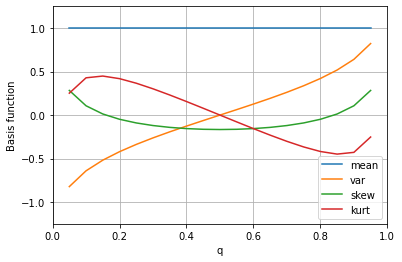

In [22]:
fig, ax = plt.subplots()
ax.plot(qs, mean_basis, label='mean')
ax.plot(qs, var_basis,  label='var')
ax.plot(qs, skew_basis, label='skew')
ax.plot(qs, kurtosis_basis, label='kurt')
ax.set(
    xlabel='q',
    ylabel='Basis function',
    xlim=(0,1), 
    ylim=(-1.25,1.25),
);
ax.legend();
ax.grid();

I think the basis functions here should probably be normalized though.

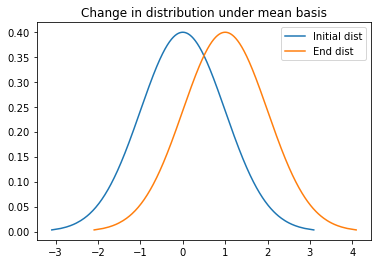

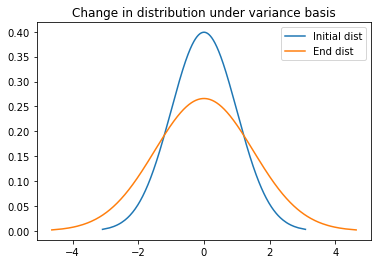

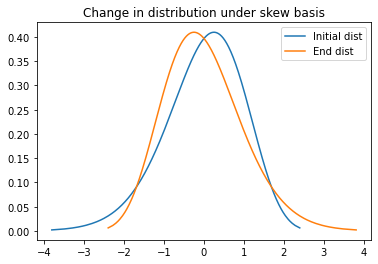

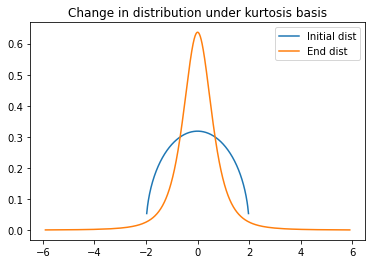

In [7]:
start_dist_list = ['norm', 'norm', 'pearson3', 'beta']
end_dist_list = ['norm', 'norm', 'pearson3', pearson7]    # Pearson7 is user-defined

start_args = [
    {'loc' : 0, 'scale':1},
    {'scale' : 1},
    {'loc': 0, 'scale':1, 'skew':-0.5},
    {'a': 1.5, 'b':1.5, 'loc':-2, 'scale': 4}
]
end_args = [
    {'loc' : 1, 'scale':1},
    {'scale' : 1.5},
    {'loc': 0, 'scale':1, 'skew':0.5},
    {'shape':2, 'loc': 0, 'scale': 1}
]
moments = ['mean', 'variance', 'skew', 'kurtosis']

for i in range(4):
    start_dist = getattr(sc.stats, start_dist_list[i])
    start_quantiles = start_dist.ppf(qs, **start_args[i])
    
    if isinstance(end_dist_list[i], str):
        end_dist = getattr(sc.stats, start_dist_list[i])
    else:
        end_dist = end_dist_list[i]
    end_quantiles = end_dist.ppf(qs, **end_args[i])

    fig, ax = plt.subplots()
    ax.plot(start_quantiles, start_dist.pdf(start_quantiles, **start_args[i]), label='Initial dist')
    ax.plot(end_quantiles, end_dist.pdf(end_quantiles, **end_args[i]), label='End dist')
    ax.set_title('Change in distribution under {} basis'.format(moments[i]))
    ax.legend()

In [8]:
print(pearson3.stats(loc=0, scale=1, skew=-0.5, moments='mvsk'))
print(beta.stats(a=1.5, b=1.5, loc=-2, scale=4, moments='mvsk'))

(array(0.), array(1.), array(-0.5), array(0.375))
(array(0.), array(1.), array(0.), array(-1.))


## Create nonstationary distribution

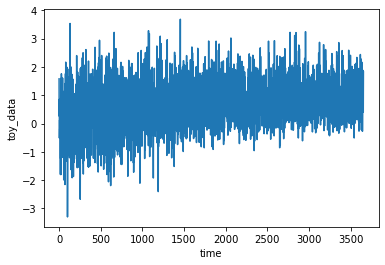

In [9]:
rng = np.random.default_rng(0)
n = 3653
data = np.zeros(n)
for i in range(n):
    data[i] = sc.stats.skewnorm.rvs(loc=0.1*i/n, a=0.001*i)
    # data[i] = norm.rvs(loc=0.1*i/n, scale=1 + 1*np.log(i+1))
timeseries = xr.DataArray(
    data, dims=('time',), coords={'time':np.arange(n)}, name='toy_data'
)
timeseries.plot()

## Perform quantile regression

In [10]:
# Preprocessing stuff
df = timeseries.to_dataframe().reset_index()
y, x = dmatrices('toy_data ~ time', data=df, return_type='dataframe')

In [11]:
# Perform quantile regression for a given quantile
qr = sm.regression.quantile_regression.QuantReg(y, x) 
result = qr.fit(q=0.05)
pred = result.predict(x)

Text(0.5, 1.0, 'Quantile regression on data with 19 quantiles')

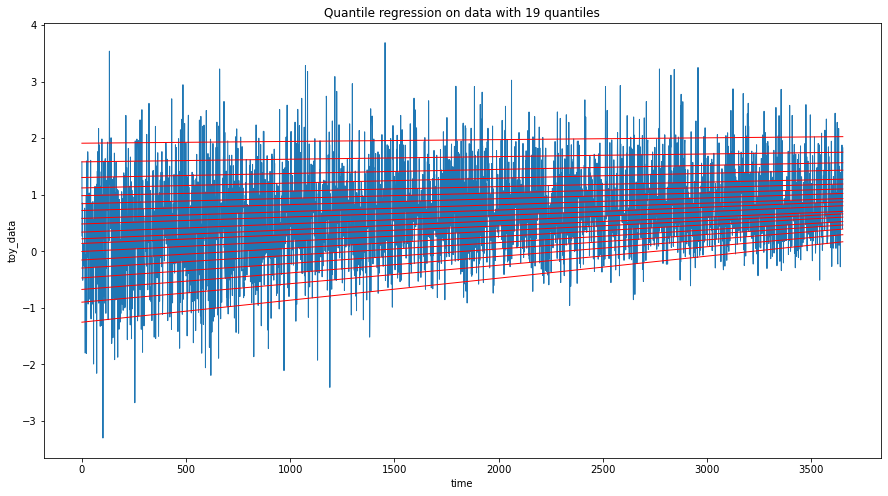

In [14]:
# Plot example quantile regression
fig, ax = plt.subplots(figsize=(15,8))
timeseries.plot(ax=ax, lw=1)

qs = np.arange(0.05, 1.0, 0.05)

for q in qs:
    result = qr.fit(q=q)
    ax.plot(x['time'], result.predict(x), color='r', ls='-', lw=1)

ax.set_title('Quantile regression on data with {} quantiles'.format(len(qs)))

In [15]:
# Compute quantile changes for distribution
quantile_changes = np.zeros(len(qs))
for i, q in enumerate(qs):
    result = qr.fit(q=q)
    quantile_changes[i] = np.array(result.predict(x))[-1] - np.array(result.predict(x))[0]

[Text(0, 0.5, 'Change'),
 Text(0.5, 0, 'q'),
 Text(0.5, 1.0, 'Quantile changes for timeseries')]

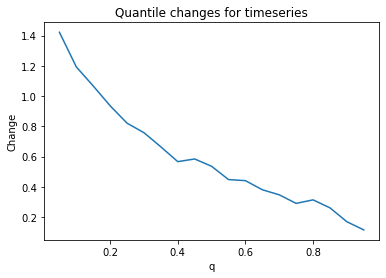

In [16]:
fig, ax = plt.subplots()
ax.plot(qs, quantile_changes)
ax.set(
    title='Quantile changes for timeseries',
    xlabel='q',
    ylabel='Change'
)

## Construct least squares solution

In [35]:
A = np.zeros((len(qs), 4))
A[:,0] = mean_basis
A[:,1] = var_basis
A[:,2] = skew_basis
A[:,3] = kurtosis_basis

coeffs = sc.linalg.lstsq(A, quantile_changes)[0]
coeffs

array([ 0.62057785, -0.81459286,  0.58929241, -0.04887844])

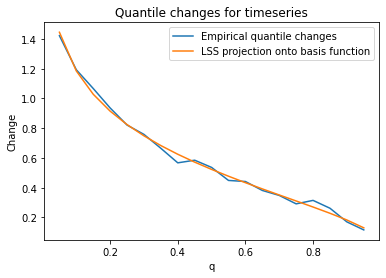

In [38]:
fig, ax = plt.subplots()
ax.plot(qs, quantile_changes, label='Empirical quantile changes')
ax.plot(qs, A@coeffs, label='LSS projection onto basis function')
ax.set(
    title='Quantile changes for timeseries',
    xlabel='q',
    ylabel='Change'
)
ax.legend()